In [0]:
!pip install -U -q PyDrive
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -q /content/gdrive/My\ Drive/BigData/data/train.csv.zip 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

dataPreparation = drive.CreateFile({'id':'1_FwvAUOGuHrzZo9BPrT8vUN7NzdiyiJ2'})
dataPreparation.GetContentFile('dataPreparation.py')

constants = drive.CreateFile({'id':'19gmw2h2VRgJC3O2RysRQ4zPWvoIJxQCY'})
constants.GetContentFile('constants.py')

utils = drive.CreateFile({'id':'1MXNAGTilvvyXG8wtxcPAo5aRK3cMElE1'})
utils.GetContentFile('utils.py')


In [0]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import dataPreparation
import utils
import constants

In [0]:

trainNoClean,testNoClean = dataPreparation.readDataforAnalysis('./train.csv','/content/gdrive/My Drive/BigData/data/test.csv')
print("Shape of Training Data before cleaning ",trainNoClean.shape)
print("Shape of Testing Data before cleaning", testNoClean.shape)


train,test = dataPreparation.readAndCleanData('./train.csv','/content/gdrive/My Drive/BigData/data/test.csv')
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)

# TODO: Call function for dataAnalysis here.

# For ( heba & fatema but sobhy & feryal will use train & test above only)
# For training and testing using models.
# xTrain, xTest, yTrain, yTest \
# =dataPreparation.prepareDataForModel(train,'fare_amount',dropCols=['key','pickup_datetime'],isTrain=True,split=0.2)

# testData=dataPreparation.prepareDataForModel(test,'fare_amount',dropCols=['key','pickup_datetime'],isTrain=False)

# TODO: Call model training and testing here.


Shape of Training Data before cleaning  (6000000, 8)
Shape of Testing Data before cleaning (9914, 7)


/content/dataPreparation.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
/content/dataPreparation.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
/content/dataPreparation.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

Shape of Training Data after cleaning  (2935680, 13)
Shape of Testing Data after cleaning (9914, 12)


In [0]:
# 27,28.29
train['is_pickup_JFK']=train.apply(lambda row:utils.isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
train['is_dropoff_JFK']=train.apply(lambda row:utils.isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

train['is_pickup_EWR']=train.apply(lambda row:utils.isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
train['is_dropoff_EWR']=train.apply(lambda row:utils.isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

train['is_pickup_la_guardia']=train.apply(lambda row:utils.isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
train['is_dropoff_la_guardia']=train.apply(lambda row:utils.isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)



In [0]:
non_airport=train.loc[(train['is_dropoff_JFK']==0) & (train['is_dropoff_EWR']==0) & (train['is_dropoff_la_guardia']==0)]
non_airport=non_airport.loc[(non_airport['is_pickup_JFK']==0) & (non_airport['is_pickup_EWR']==0) & (non_airport['is_pickup_la_guardia']==0)]
non_airport.shape

Text(0.5, 1.0, 'Distribution of Trip Fare')

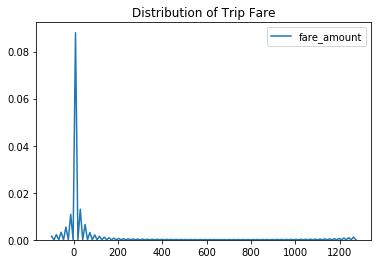

In [0]:
#Let's plot the probabilty distribution of fare amount (kernel density estimate)
sns.kdeplot(trainNoClean['fare_amount']).set_title("Distribution of Trip Fare")

In [0]:
# some rows have negative fare amount
print("Data with negative fare amount")
print(trainNoClean.loc[trainNoClean['fare_amount']<0].shape)
# take only rows with zero or positive fare amount
print("Data after excluding negative fare amount")
trainNoClean=trainNoClean.loc[trainNoClean['fare_amount']>=0]
trainNoClean.shape


Data with negative fare amount
(262, 8)
Data after excluding negative fare amount


(5999738, 8)

In [0]:
#Let's now explore the pickup and dropoff latitude and longitude
print("Range of Pickup Latitude is ", (min(trainNoClean['pickup_latitude']),
                                       max(trainNoClean['pickup_latitude'])))

print("Range of Dropoff Latitude is ", (min(trainNoClean['dropoff_latitude']),
                                        max(trainNoClean['dropoff_latitude'])))

print("Range of Pickup longitude is ", (min(trainNoClean['pickup_longitude']),
                                        max(trainNoClean['pickup_longitude'])))

print("Range of Dropoff longitude is ", (min(trainNoClean['dropoff_longitude']),
                                         max(trainNoClean['dropoff_longitude'])))

Range of Pickup Latitude is  (-3488.079513, 3344.459268)
Range of Dropoff Latitude is  (-3488.079513, 3345.9173530000003)
Range of Pickup longitude is  (-3426.60895, 3439.425565)
Range of Dropoff longitude is  (-3412.6530869999997, 3457.62235)


In [0]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)


Text(0.5, 1.0, 'Avg Fare Amount vs Passenger Count')

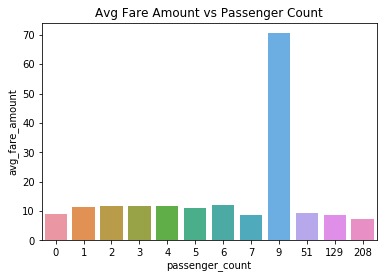

In [22]:
passenger_fareamount=trainNoClean.groupby(['passenger_count'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

sns.barplot(x='passenger_count',y='avg_fare_amount',data=passenger_fareamount).set_title("Avg Fare Amount vs Passenger Count")

In [0]:
trainNoClean.loc[trainNoClean['passenger_count']>6].shape

(12, 8)

In [0]:
dataClean = dataPreparation.cleanData(trainNoClean)


/content/dataPreparation.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
/content/dataPreparation.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
/content/dataPreparation.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [0]:
# 27,28.29
dataClean['is_pickup_JFK']=dataClean.apply(lambda row:utils.isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
dataClean['is_dropoff_JFK']=dataClean.apply(lambda row:utils.isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

dataClean['is_pickup_EWR']=dataClean.apply(lambda row:utils.isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
dataClean['is_dropoff_EWR']=dataClean.apply(lambda row:utils.isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

dataClean['is_pickup_la_guardia']=dataClean.apply(lambda row:utils.isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
dataClean['is_dropoff_la_guardia']=dataClean.apply(lambda row:utils.isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)


In [0]:
#34
non_airport=dataClean.loc[(dataClean['is_dropoff_JFK']==0) & (dataClean['is_dropoff_EWR']==0) & (dataClean['is_dropoff_la_guardia']==0)]
non_airport=non_airport.loc[(non_airport['is_pickup_JFK']==0) & (non_airport['is_pickup_EWR']==0) & (non_airport['is_pickup_la_guardia']==0)]
non_airport.shape


In [0]:
airport_trips=dataClean.loc[(dataClean['is_dropoff_JFK']==1) | (dataClean['is_dropoff_EWR']==1) | (dataClean['is_dropoff_la_guardia']==1) | \
                        (dataClean['is_pickup_JFK']==1) | (dataClean['is_pickup_EWR']==1) | (dataClean['is_pickup_la_guardia']==1)]
airport_trips_dropoff = dataClean.loc[(dataClean['is_dropoff_JFK']==1) | (dataClean['is_dropoff_EWR']==1) | (dataClean['is_dropoff_la_guardia']==1)]
airport_trips_pickup = dataClean.loc[(dataClean['is_pickup_JFK']==1) | (dataClean['is_pickup_EWR']==1) | (dataClean['is_pickup_la_guardia']==1)]
airport_trips.shape

(324040, 21)

In [0]:
#40
dataClean['pickup_borough']=dataClean.apply(lambda row:utils.getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
dataClean['dropoff_borough']=dataClean.apply(lambda row:utils.getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [0]:
airport_and_boroughs = dataClean.loc[(dataClean['is_dropoff_JFK']==1) | (dataClean['is_dropoff_EWR']==1) | (dataClean['is_dropoff_la_guardia']==1) | \
                        (dataClean['is_pickup_JFK']==1) | (dataClean['is_pickup_EWR']==1) | (dataClean['is_pickup_la_guardia']==1) | \
                        (dataClean['pickup_borough']!= "others") | (dataClean['dropoff_borough']!= "others" )]

In [0]:
# (dataClean['is_pickup_JFK']==1) | (dataClean['is_pickup_EWR']==1) | (dataClean['is_pickup_la_guardia']==1) | 
# (dataClean['is_dropoff_JFK']==1) | (dataClean['is_dropoff_EWR']==1) | (dataClean['is_dropoff_la_guardia']==1) |
airport_and_boroughs_pickup = dataClean.loc[(dataClean['pickup_borough' ]== 'others')]
airport_and_boroughs_dropoff = dataClean.loc[(dataClean['dropoff_borough']!= "others")]

In [0]:
#46,47
dataClean['is_pickup_lower_manhattan']=dataClean.apply(lambda row:utils.isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
dataClean['is_dropoff_lower_manhattan']=dataClean.apply(lambda row:utils.isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [0]:
manhattan=dataClean.loc[(dataClean['pickup_borough']=='manhattan') | (dataClean['dropoff_borough']=='manhattan')]
manhattan.shape

In [0]:
dataClean['fare_amount'].describe().apply(lambda x: format(x, 'f'))

count    5871290.000000
mean          11.312098
std            9.637003
min            0.000000
25%            6.000000
50%            8.500000
75%           12.500000
max          952.000000
Name: fare_amount, dtype: object

Text(0.5, 1.0, 'Distribution of fare amount')

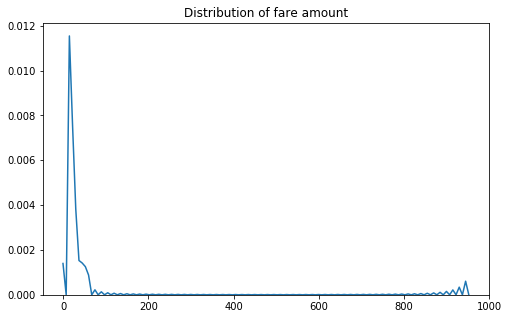

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot((dataClean['fare_amount'].values)).set_title("Distribution of fare amount")

In [0]:
# This wide range of longitude and latitude are not actually new york city ranges
#so using the test set we found the actual longitudes and latitudes we will keep and mark the others as outliers
print("Range of Dropoff Latitude is", min(dataClean.pickup_latitude.min(), dataClean.dropoff_latitude.min()),
                  max(dataClean.pickup_latitude.max(), dataClean.dropoff_latitude.max())) 
print("Range of Dropoff Longitude is",min(dataClean.pickup_longitude.min(), dataClean.dropoff_longitude.min()),
      max(dataClean.pickup_longitude.max(), dataClean.dropoff_longitude.max()))



Range of Dropoff Latitude is 40.573188 41.706312
Range of Dropoff Longitude is -74.26321 -72.99715


(-74.03, -73.75)

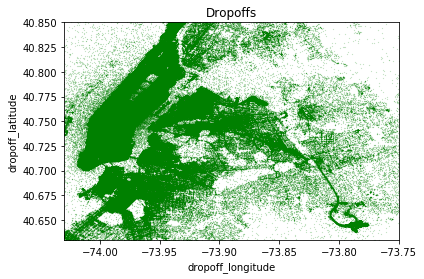

In [0]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

dataClean.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

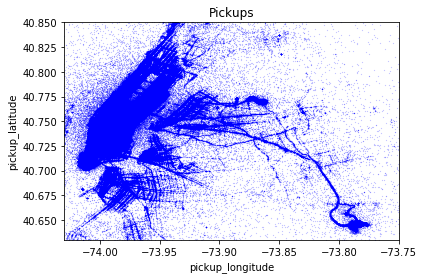

In [0]:
dataClean.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)


Text(0.5, 1.0, 'Pickups')

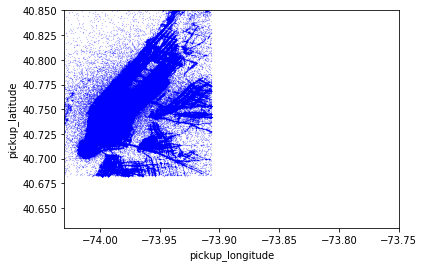

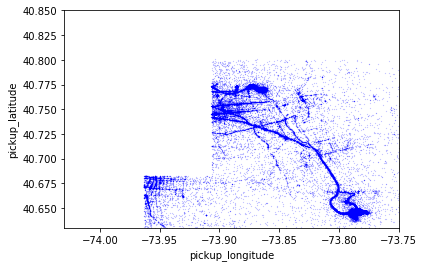

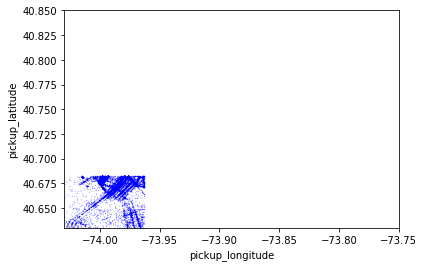

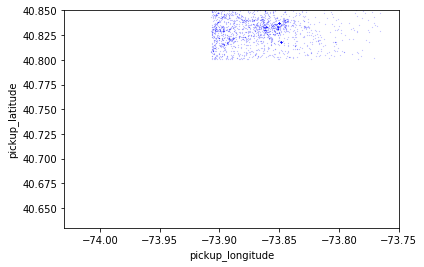

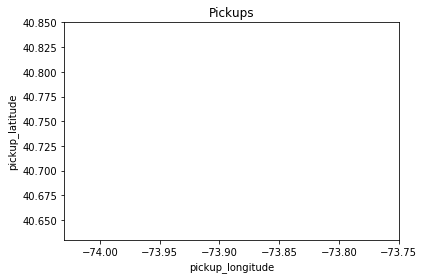

In [0]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
for key in constants.nyc_boroughs.keys():
  manData = dataClean.loc[(dataClean['pickup_borough']== key)]
  manData.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
  plt.ylim(city_lat_border)
  plt.xlim(city_long_border)
plt.title("Pickups")



In [0]:
dataClean['pickup_distance_JFK']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.jfk[1],row['pickup_longitude'],constants.jfk[0]),axis=1)
dataClean['dropoff_distance_JFK']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.jfk[1],row['dropoff_longitude'],constants.jfk[0]),axis=1)
dataClean['pickup_distance_EWR']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.ewr[1],row['pickup_longitude'],constants.ewr[0]),axis=1)
dataClean['dropoff_distance_EWR']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.ewr[1],row['dropoff_longitude'],constants.ewr[0]),axis=1)
dataClean['pickup_distance_LaGuardia']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.lgr[1],row['pickup_longitude'],constants.lgr[0]),axis=1)
dataClean['dropoff_distance_LaGuardia']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.lgr[1],row['dropoff_longitude'],constants.lgr[0]),axis=1)

dataClean['pickup_distance_manhattan']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.manhattan[1],row['pickup_longitude'],constants.manhattan[0]),axis=1)
dataClean['pickup_distance_queens']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.queens[1],row['pickup_longitude'],constants.queens[0]),axis=1)
dataClean['pickup_distance_brooklyn']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.brooklyn[1],row['pickup_longitude'],constants.brooklyn[0]),axis=1)
dataClean['pickup_distance_bronx']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.bronx[1],row['pickup_longitude'],constants.bronx[0]),axis=1)
dataClean['pickup_distance_statenisland']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],constants.staten_island[1],row['pickup_longitude'],constants.staten_island[0]),axis=1)
dataClean['dropoff_distance_manhattan']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.manhattan[1],row['dropoff_longitude'],constants.manhattan[0]),axis=1)
dataClean['dropoff_distance_queens']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.queens[1],row['dropoff_longitude'],constants.queens[0]),axis=1)
dataClean['dropoff_distance_brooklyn']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.brooklyn[1],row['dropoff_longitude'],constants.brooklyn[0]),axis=1)
dataClean['dropoff_distance_bronx']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.bronx[1],row['dropoff_longitude'],constants.bronx[0]),axis=1)
dataClean['dropoff_distance_statenisland']=dataClean.apply(lambda row:utils.distance(row['dropoff_latitude'],constants.staten_island[1],row['dropoff_longitude'],constants.staten_island[0]),axis=1)


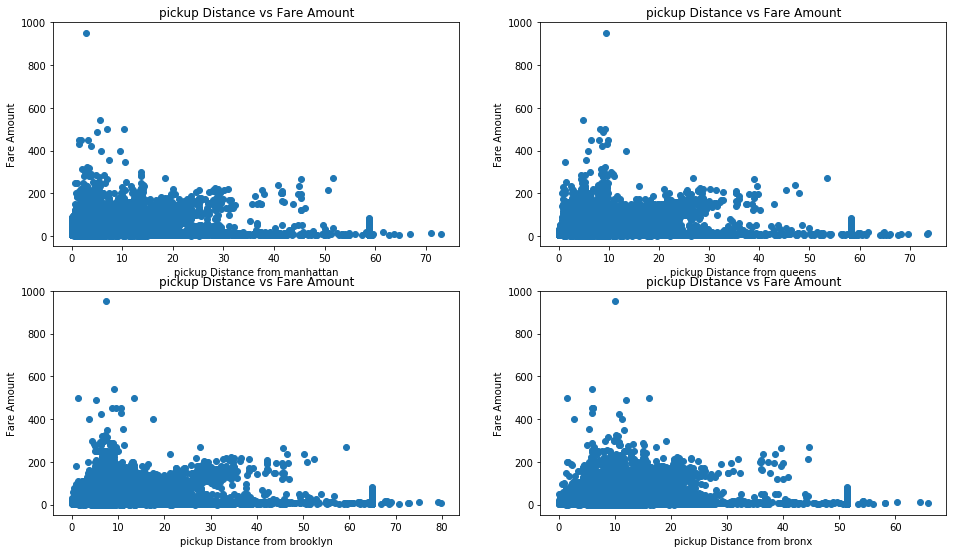

In [0]:
plt.figure(figsize=(16,14))
plt.title("Distribution of Fare Amount vs Distance from boroughs")
i=1

for key in constants.nyc_boroughs.keys():
  
  if key != 'staten_island':
    plt.subplot(3,2,i)
    plt.scatter(x=dataClean['pickup_distance_'+key],y=dataClean['fare_amount'])
    plt.xlabel("pickup Distance from "+key)
    plt.ylabel("Fare Amount")
    plt.title("pickup Distance vs Fare Amount")
    i=i+1
  

Text(0.5, 1.0, 'pickup Distance vs Fare Amount')

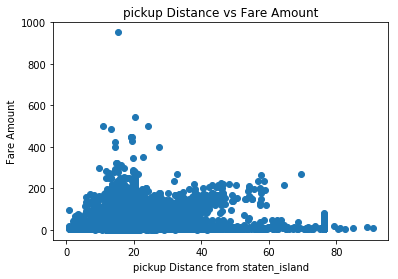

In [0]:
plt.scatter(x=dataClean['pickup_distance_statenisland'],y=dataClean['fare_amount'])
plt.xlabel("pickup Distance from staten_island")
plt.ylabel("Fare Amount")
plt.title("pickup Distance vs Fare Amount")

In [0]:
JFK_data=dataClean.loc[(dataClean.pickup_latitude>=constants.nyc_airports['JFK']['min_lat']) & (dataClean.pickup_latitude<=constants.nyc_airports['JFK']['max_lat'])]
JFK_data=JFK_data.loc[(dataClean.pickup_longitude>=constants.nyc_airports['JFK']['min_lng']) & (dataClean.pickup_longitude<=constants.nyc_airports['JFK']['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_data.shape[0])

JFK_dropoff=dataClean.loc[(dataClean.dropoff_latitude>=constants.nyc_airports['JFK']['min_lat']) & (dataClean.dropoff_latitude<=constants.nyc_airports['JFK']['max_lat'])]
JFK_dropoff=JFK_dropoff.loc[(dataClean.dropoff_longitude>=constants.nyc_airports['JFK']['min_lng']) & (dataClean.dropoff_longitude<=constants.nyc_airports['JFK']['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])

In [0]:
EWR_data=dataClean.loc[(dataClean.pickup_latitude>=constants.nyc_airports['EWR']['min_lat']) & (dataClean.pickup_latitude<=constants.nyc_airports['EWR']['max_lat'])]
EWR_data=EWR_data.loc[(dataClean.pickup_longitude>=constants.nyc_airports['EWR']['min_lng']) & (dataClean.pickup_longitude<=constants.nyc_airports['EWR']['max_lng'])]

print("Number of Trips with Pickups from EWR",EWR_data.shape[0])

EWR_dropoff=dataClean.loc[(dataClean.dropoff_latitude>=constants.nyc_airports['EWR']['min_lat']) & (dataClean.dropoff_latitude<=constants.nyc_airports['EWR']['max_lat'])]
EWR_dropoff=EWR_dropoff.loc[(dataClean.dropoff_longitude>=constants.nyc_airports['EWR']['min_lng']) & (dataClean.dropoff_longitude<=constants.nyc_airports['EWR']['max_lng'])]

print("Number of Trips with Dropoffs to EWR",EWR_dropoff.shape[0])

In [0]:
LaGuardia_data=dataClean.loc[(dataClean.pickup_latitude>=constants.nyc_airports['LaGuardia']['min_lat']) & (dataClean.pickup_latitude<=constants.nyc_airports['LaGuardia']['max_lat'])]
LaGuardia_data=LaGuardia_data.loc[(dataClean.pickup_longitude>=constants.nyc_airports['LaGuardia']['min_lng']) & (dataClean.pickup_longitude<=constants.nyc_airports['LaGuardia']['max_lng'])]

print("Number of Trips with Pickups from LaGuardia",LaGuardia_data.shape[0])

LaGuardia_dropoff=dataClean.loc[(dataClean.dropoff_latitude>=constants.nyc_airports['LaGuardia']['min_lat']) & (dataClean.dropoff_latitude<=constants.nyc_airports['LaGuardia']['max_lat'])]
LaGuardia_dropoff=LaGuardia_dropoff.loc[(dataClean.dropoff_longitude>=constants.nyc_airports['LaGuardia']['min_lng']) & (dataClean.dropoff_longitude<=constants.nyc_airports['LaGuardia']['max_lng'])]

print("Number of Trips with Dropoffs to LaGuardia",LaGuardia_dropoff.shape[0])

In [0]:
plt.figure(figsize=(16,10))
plt.title("Fare Amount Distribution for Airports pickups")
plt.subplot(2,2,1)
sns.kdeplot(JFK_data['fare_amount'].values,label='JFK Pickups')
sns.kdeplot(dataClean['fare_amount'].values,label='All Trips in Train data').set_title("JFK Airport")
plt.subplot(2,2,2)
sns.kdeplot(EWR_data['fare_amount'].values,label='EWR Pickups')
sns.kdeplot(dataClean['fare_amount'].values,label='All Trips in Train data').set_title("EWR Airport")
plt.subplot(2,2,3)
sns.kdeplot(LaGuardia_data['fare_amount'].values,label='LaGuardia Pickups')
sns.kdeplot(dataClean['fare_amount'].values,label='All Trips in Train data').set_title("LaGuardia Airport")

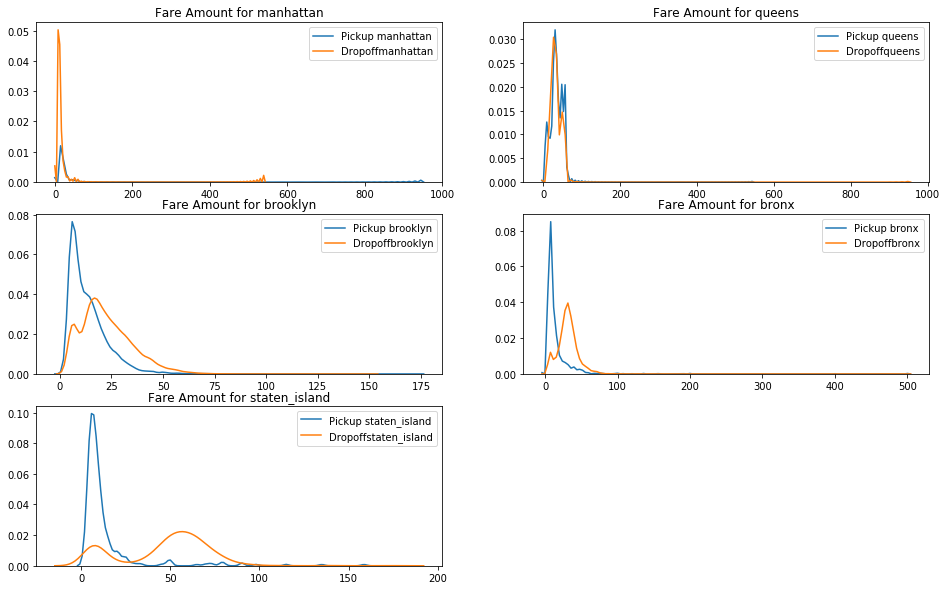

In [0]:

plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for    key in constants.nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot((dataClean.loc[dataClean['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot((dataClean.loc[dataClean['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount for "+key)
    
    i=i+1

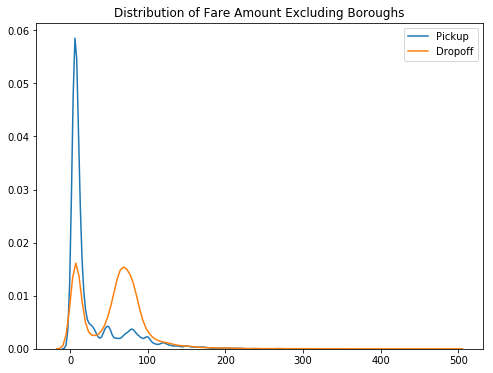

In [0]:
plt.figure(figsize=(8,6))
plt.title("Distribution of Fare Amount Excluding Boroughs")
sns.kdeplot((dataClean.loc[dataClean['pickup_borough']=="others",'fare_amount'].values),label='Pickup')
sns.kdeplot((dataClean.loc[dataClean['dropoff_borough']=="others",'fare_amount'].values),label='Dropoff')
    

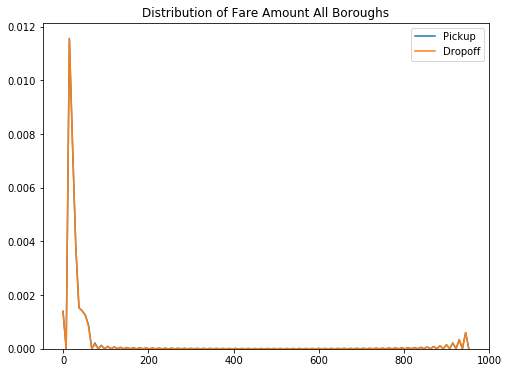

In [0]:
plt.figure(figsize=(8,6))
plt.title("Distribution of Fare Amount All Boroughs")
sns.kdeplot((dataClean.loc[dataClean['pickup_borough']!="others",'fare_amount'].values),label='Pickup')
sns.kdeplot((dataClean.loc[dataClean['dropoff_borough']!="others",'fare_amount'].values),label='Dropoff')
    

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot((manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Pickups')
sns.kdeplot((manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Pickups')
plt.xlabel("fare amount ")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot((manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Dropoffs')
sns.kdeplot((manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Dropoffs')
plt.xlabel("fare amount ")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

In [0]:
#31
dataClean['trip_distance']=dataClean.apply(lambda row:utils.distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)


In [0]:
dataClean = dataClean[dataClean['trip_distance']>0]
dataClean['trip_distance'].describe().apply(lambda x: format(x, 'f'))

count    5809139.000000
mean           2.087566
std            2.337506
min            0.000044
25%            0.793985
50%            1.351586
75%            2.447495
max           71.828272
Name: trip_distance, dtype: object

Text(0.5, 1.0, 'Distribution of trip distance')

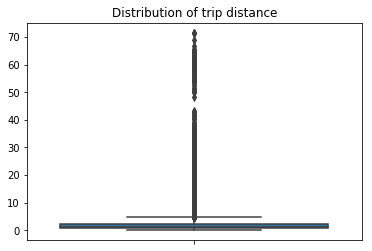

In [0]:
sns.boxplot( y= (dataClean['trip_distance'].values)).set_title("Distribution of trip distance")


Text(0.5, 1.0, 'Distribution of long-trip distance')

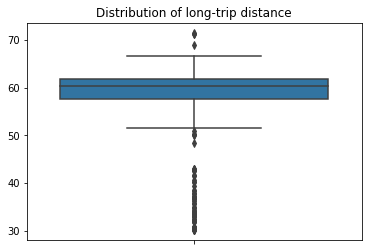

In [0]:
longTrips = dataClean[train['trip_distance']>30]
sns.boxplot( y= (longTrips['trip_distance'].values)).set_title("Distribution of long-trip distance")

Text(0.5, 1.0, 'Distribution of trip distance')

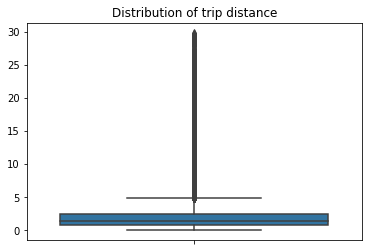

In [0]:
shortTrips = dataClean[train['trip_distance']<=30]
sns.boxplot( y= (shortTrips['trip_distance'].values)).set_title("Distribution of trip distance")


Text(0.5, 1.0, 'Distribution of trip distance)')

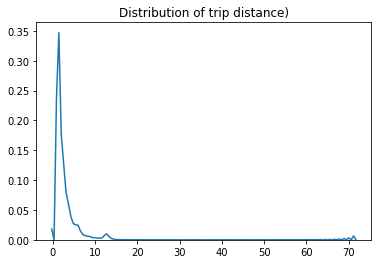

In [0]:
sns.kdeplot((dataClean['trip_distance'].values)).set_title("Distribution of trip distance)")


Text(0.5, 1.0, 'Distribution of trip distance(zoomed in)')

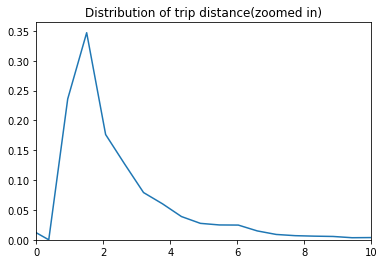

In [0]:
plt.xlim(0,10)
sns.kdeplot((dataClean['trip_distance'].values)).set_title("Distribution of trip distance(zoomed in)")


Text(0.5, 1.0, 'Distribution of fare amount(log scale)')

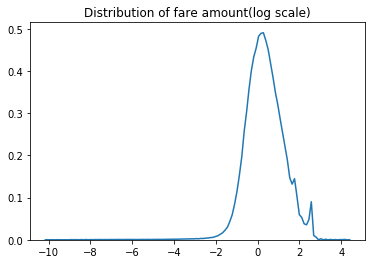

In [0]:
#32
sns.kdeplot(np.log(dataClean['trip_distance'].values)).set_title("Distribution of trip distance(log scale)")


Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

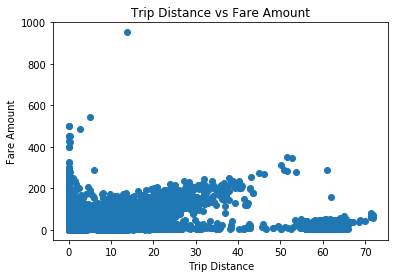

In [0]:
#33
plt.scatter(x=dataClean['trip_distance'],y=dataClean['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

Text(0.5, 1.0, 'Distribution of fare_amount for airport rides')

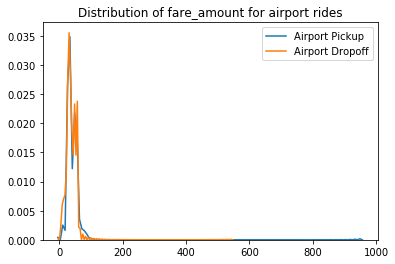

In [0]:
sns.kdeplot((airport_trips_pickup['fare_amount'].values),label = "Airport Pickup")
sns.kdeplot((airport_trips_dropoff['fare_amount'].values),label = "Airport Dropoff")
plt.title("Distribution of fare_amount for airport rides")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (airport rides)')

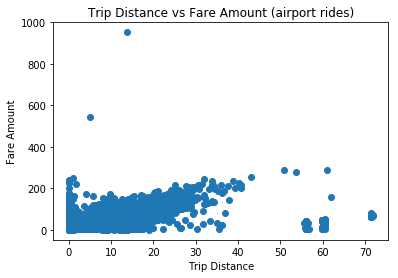

In [0]:

plt.scatter(x=airport_trips['trip_distance'],y=airport_trips['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (airport rides)")
plt.xlim(500)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport rides)')

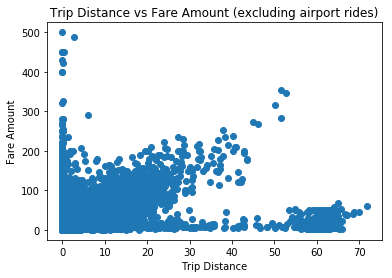

In [0]:
#35
plt.scatter(x=non_airport['trip_distance'],y=non_airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

In [0]:
non_airport_non_boroughs = non_airport.loc[dataClean['pickup_borough']=="others"]


Text(0.5, 1.0, ' Trip Distance vs Fare Amount (excluding airport rides and Boroughs)')

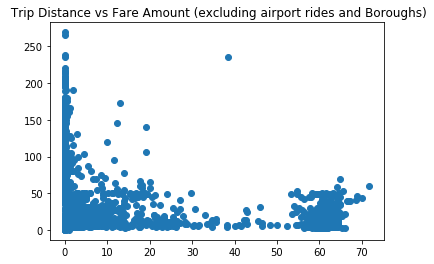

In [0]:
plt.scatter(x="trip_distance",y="fare_amount",data = non_airport_non_boroughs)
plt.title(" Trip Distance vs Fare Amount (excluding airport rides and Boroughs)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount ( Boroughs rides)')

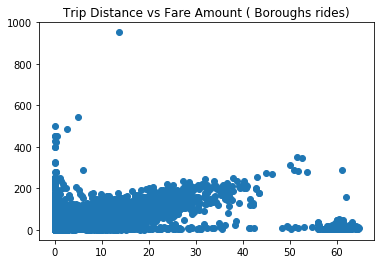

In [0]:
plt.scatter(x="trip_distance",y="fare_amount",data = dataClean.loc[dataClean['pickup_borough']!="others"])
plt.title("Trip Distance vs Fare Amount ( Boroughs rides)")

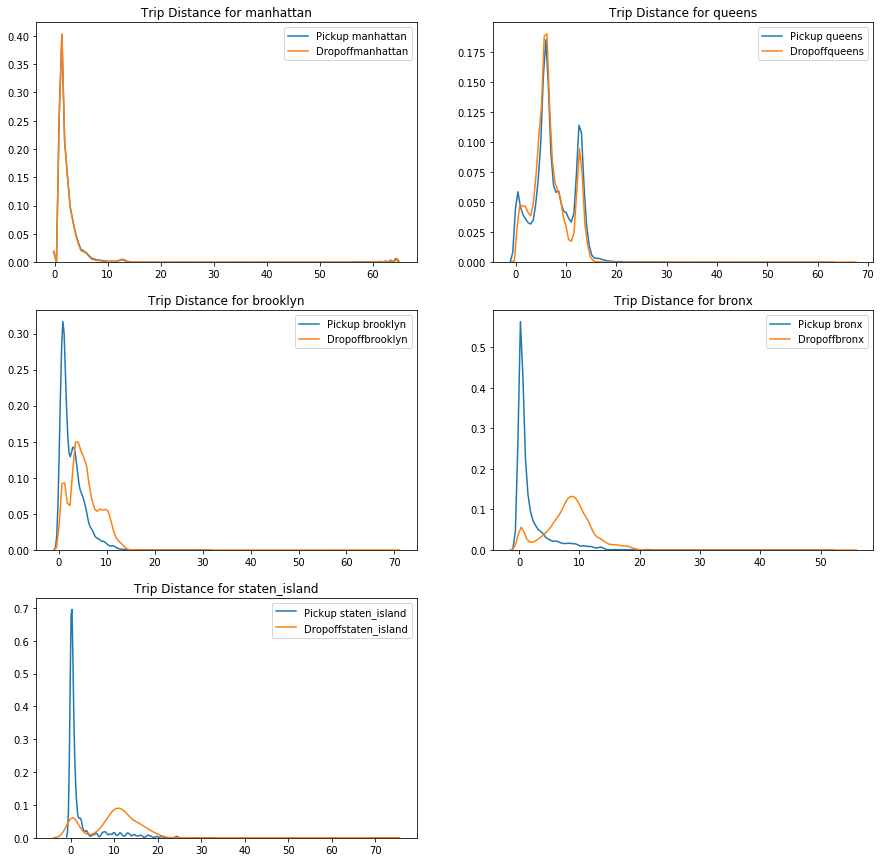

In [0]:
#44
plt.figure(figsize=(15,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in constants.nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot((dataClean.loc[dataClean['pickup_borough']==key,'trip_distance'].values),label='Pickup '+ key)
    sns.kdeplot((dataClean.loc[dataClean['dropoff_borough']==key,'trip_distance'].values),label='Dropoff'+ key).set_title("Trip Distance for "+key)
    i=i+1

(2863257, 18)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan pickups)')

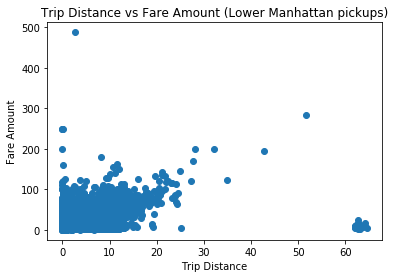

In [0]:
#50- end 
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan pickups)')

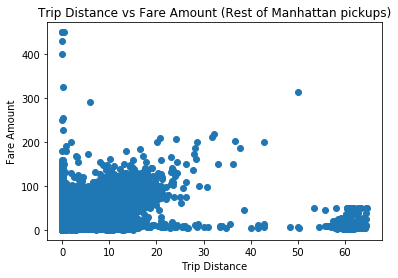

In [0]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan dropoffs)')

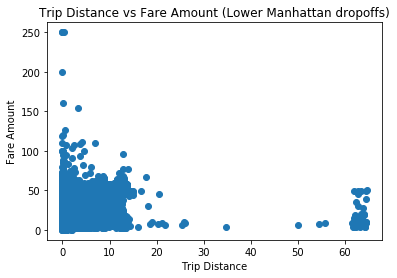

In [0]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan dropoffs)")

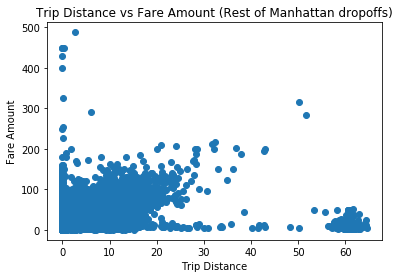

In [0]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)")

del manhattan


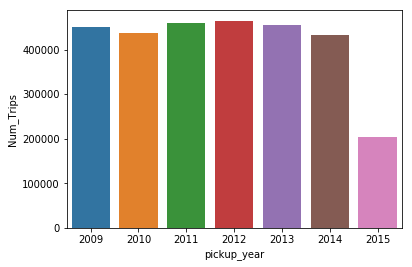

In [0]:
trips_year=dataClean.groupby(['pickup_year'])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
sns.barplot(x='pickup_year',y='Num_Trips',data=trips_year)
# sns.distplot(train['pickup_year'],kde=False)

Text(0.5, 1.0, 'Avg Fare Amount over Years')

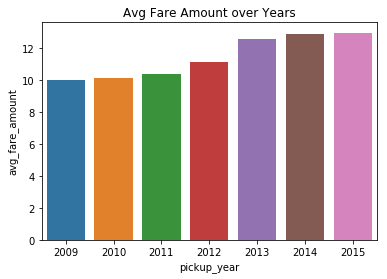

In [0]:
trips_year_fareamount=dataClean.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")

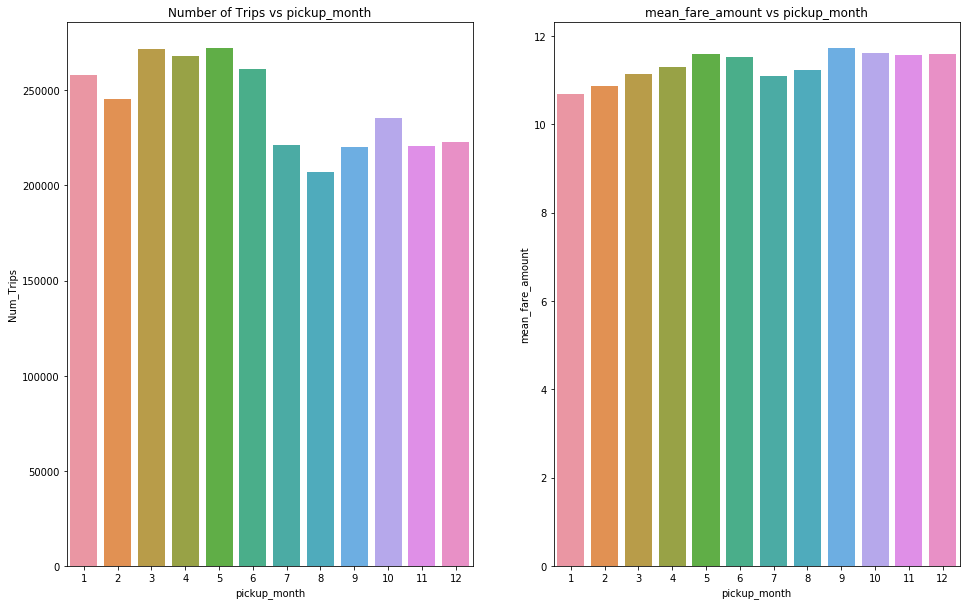

In [0]:
groupandplot(dataClean,'pickup_month','fare_amount')

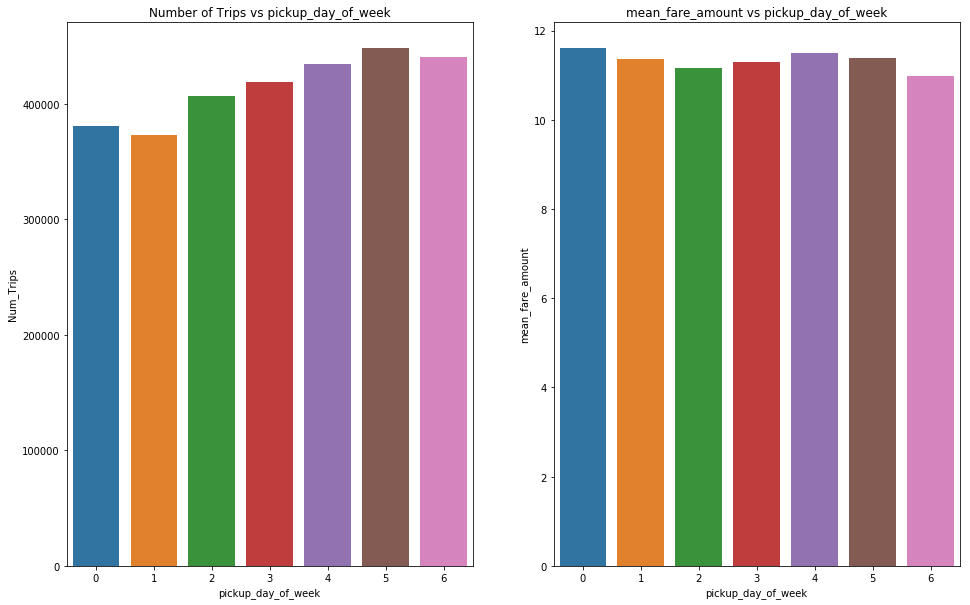

In [0]:
groupandplot(dataClean,'pickup_day_of_week','fare_amount')

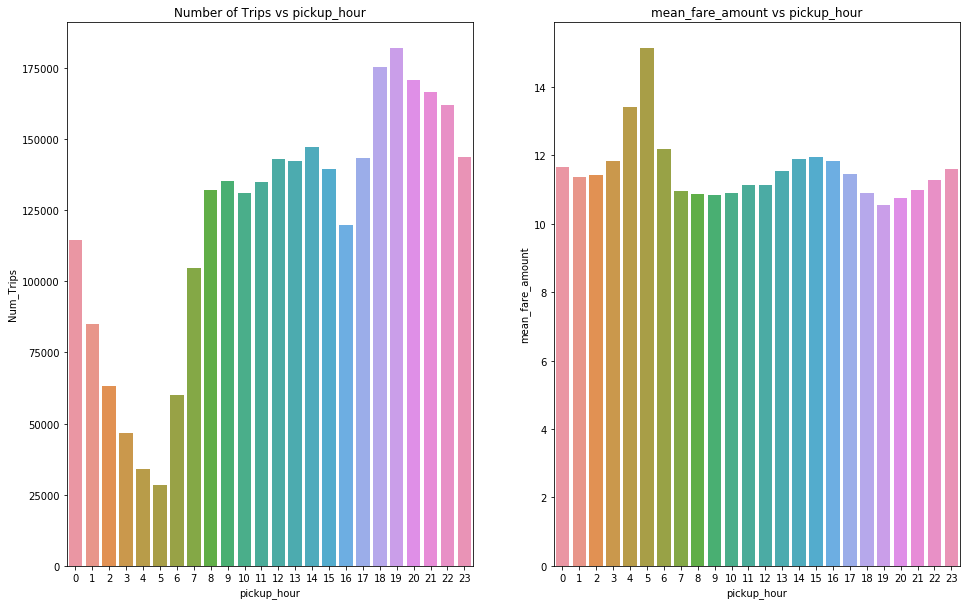

In [0]:
groupandplot(dataClean,'pickup_hour','fare_amount')

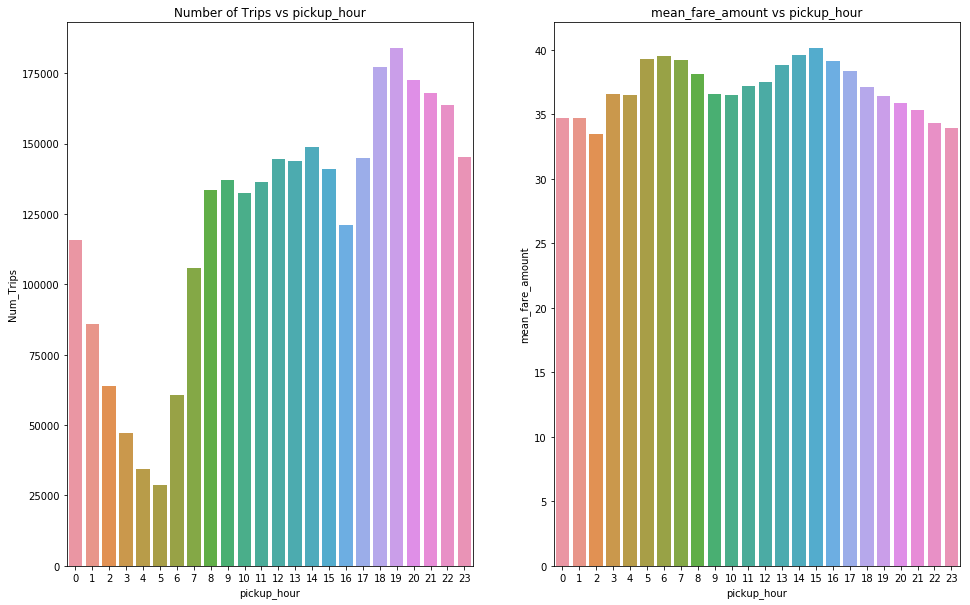

In [0]:
groupandplot(airport_trips,'pickup_hour','fare_amount')

In [0]:
groupandplot(dataClean['dropoff_borough']!='others','pickup_hour','fare_amount')

KeyError: ignored

Text(0.5, 1.0, 'pickup_hour vs latitude and longtude')

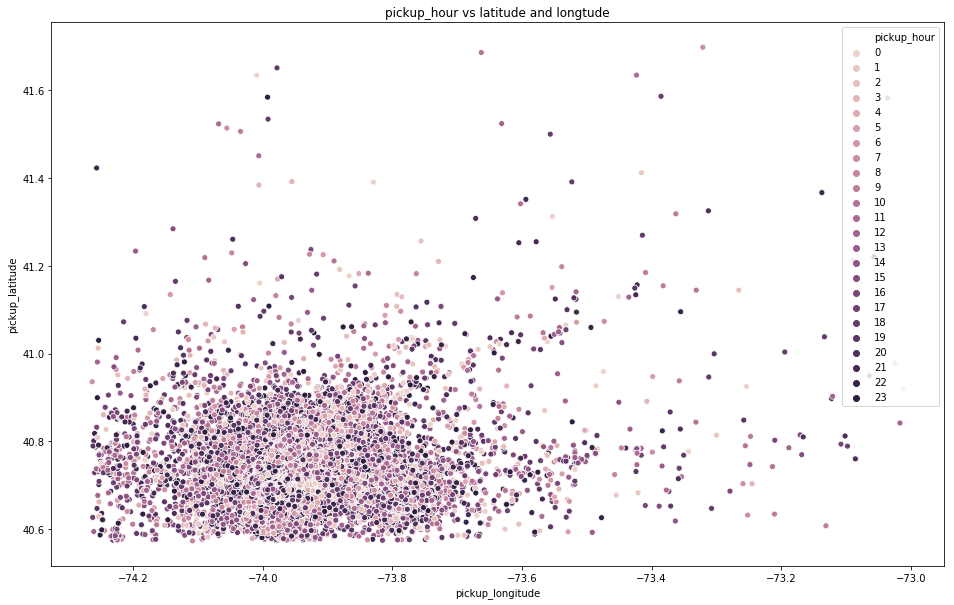

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="pickup_longitude",y="pickup_latitude",hue= "pickup_hour",legend="full",data=dataClean)
plt.xlabel("pickup_longitude")
plt.ylabel("pickup_latitude")
plt.title("pickup_hour vs latitude and longtude")


In [0]:
sns.catplot(x="pickup_latitude", y="pickup_longitude",hue="pickup_day_of_week",data = dataClean);

In [0]:
print("Avg trip distance (in miles) when there are zero passengers",np.mean(dataClean.loc[train['passenger_count']==0,'trip_distance'].values))

Avg trip distance (in miles) when there are zero passengers 1.7632650852408254


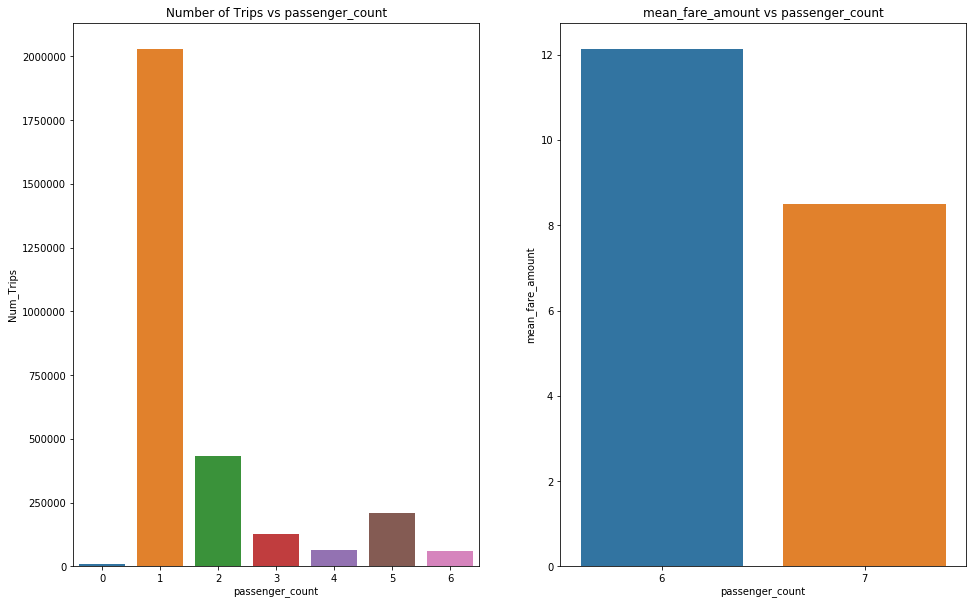

In [0]:
groupandplot(dataClean,'passenger_count','fare_amount')